<a href="https://colab.research.google.com/github/IvanKatorgin/Workshops-and-hackathons/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%BC%D1%83%D0%B7%D1%8B%D0%BA%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D1%85_%D0%B6%D0%B0%D0%BD%D1%80%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Классификация музыкальных жанров с использованием глубокого обучения. Каторгин И.П.

In [1]:
from scipy.io.wavfile import read

In [2]:
!pip install librosa

In [3]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

import sklearn

In [4]:
# распакуем архив
import zipfile

with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall('Data')  # Укажите путь для распаковки

In [6]:
audio_data = '/content/Data/genres_original/blues/blues.00000.wav'
x, sr = librosa.load(audio_data)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [7]:
sr

22050

In [8]:
x

array([ 0.00732422,  0.01660156,  0.00762939, ..., -0.05560303,
       -0.06106567, -0.06417847], dtype=float32)

In [9]:
x, sr = librosa.load(audio_data, sr=sr)

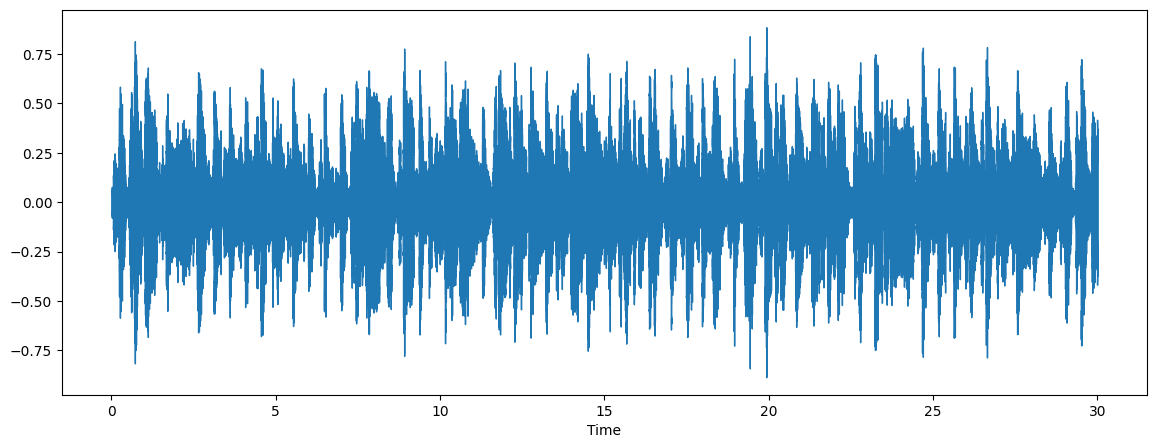

In [10]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr);

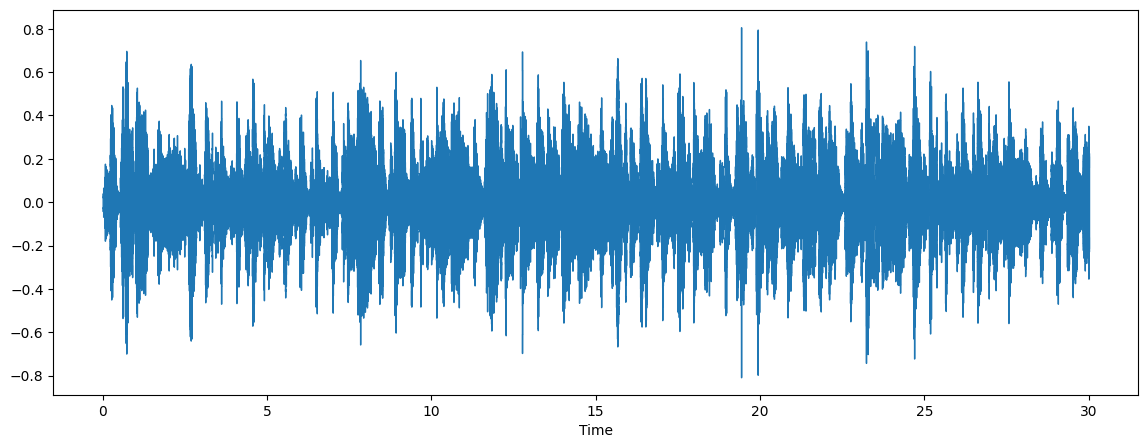

In [11]:
x, sr = librosa.load(audio_data, sr=2000)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr);

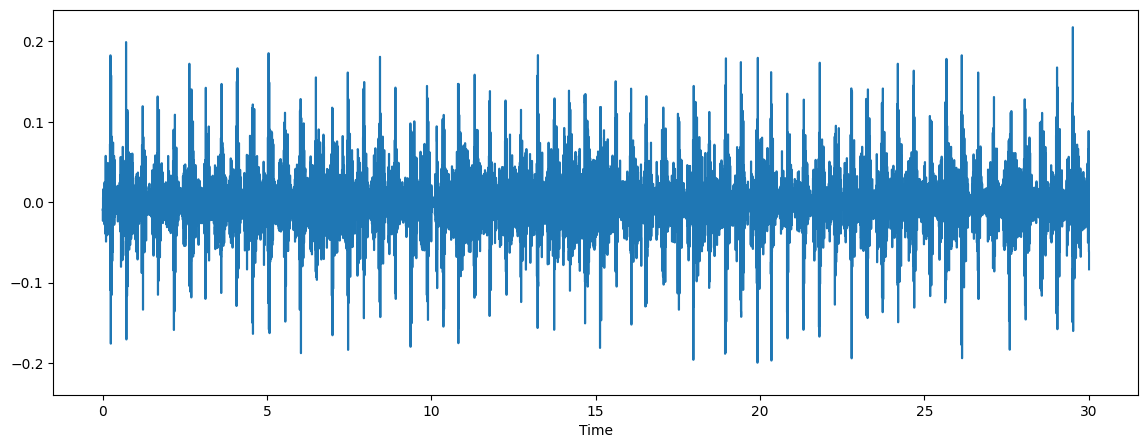

In [12]:
x, sr = librosa.load(audio_data, sr=200)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr);

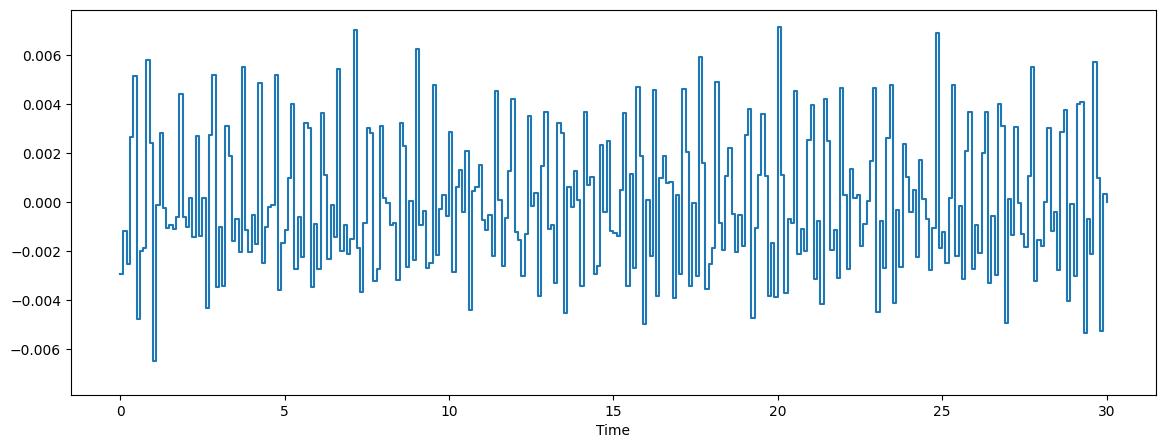

In [13]:
x, sr = librosa.load(audio_data, sr=10)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr);

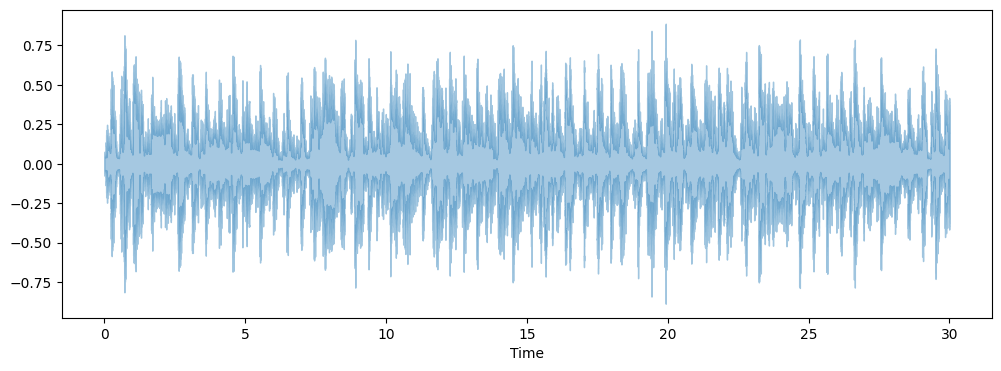

In [14]:
# Спектральный центроид

x, sr = librosa.load(audio_data, sr=44100)
spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)
spectral_centroids.shape

# Вычисление временной переменной для визуализации
plt.figure(figsize=(12, 4))

frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Нормализация спектрального центроида для визуализации
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
# Построение спектрального центроида вместе с формой волны
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b');

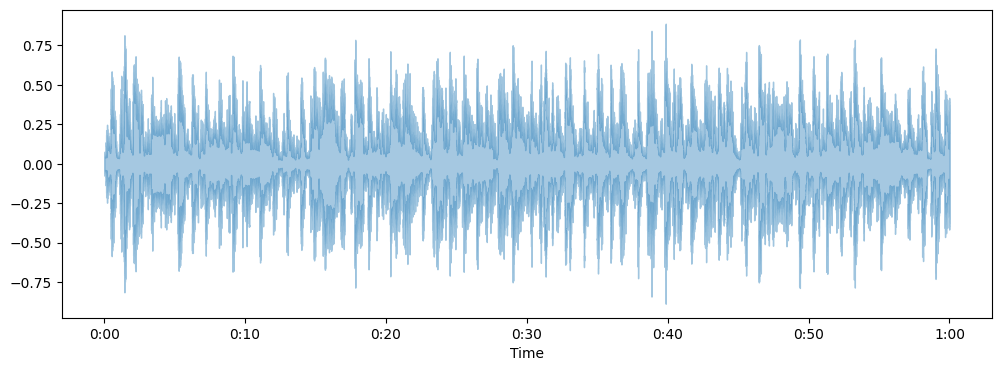

In [15]:
# Спектральный спад

y, sr = librosa.load(librosa.ex('trumpet'))
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr);
plt.figure(figsize=(12, 4))

librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r');

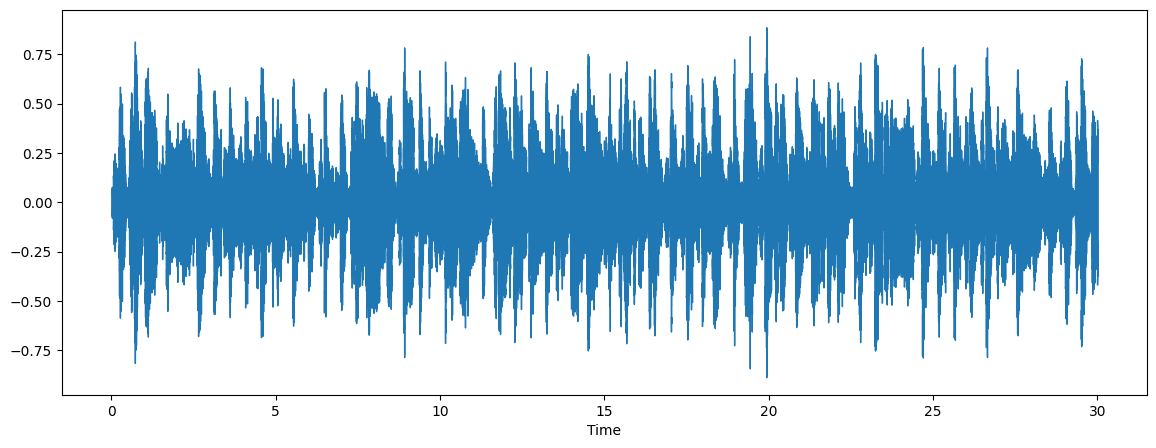

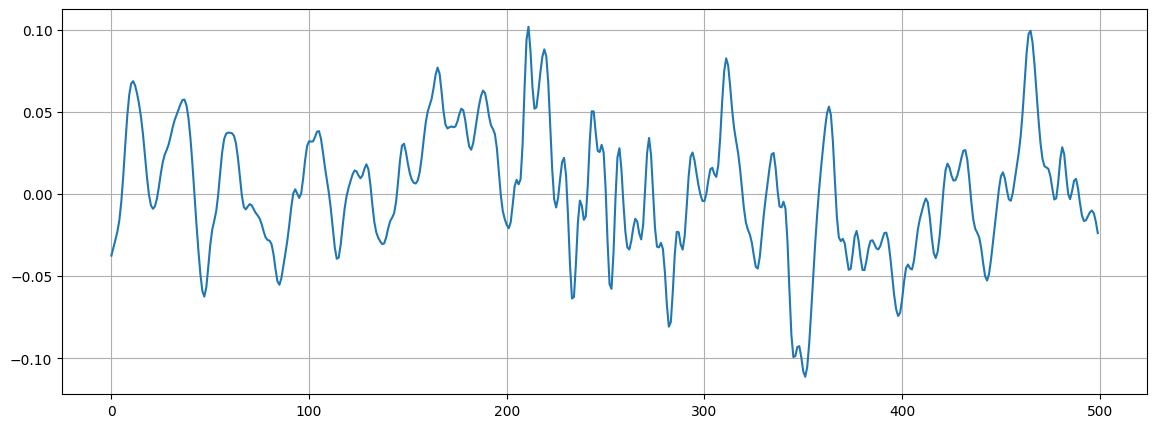

In [16]:
# Скорость пересечения нуля
x, sr = librosa.load(audio_data, sr=44100)
# Построение графика сигнала:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
# Увеличение масштаба:
n0 = 9000
n1 = 9500
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()


In [17]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

42


(20, 1293)


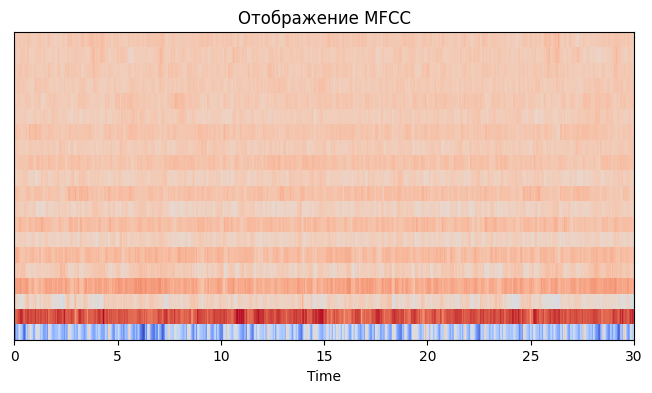

In [18]:
audio_data = '/content/Data/genres_original/blues/blues.00000.wav'
x, sr = librosa.load(audio_data)

mfccs = librosa.feature.mfcc(y = x, sr=22050)
print(mfccs.shape)
# Отображение MFCC:
plt.figure(figsize=(8, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.title('Отображение MFCC');

(20, 1293)


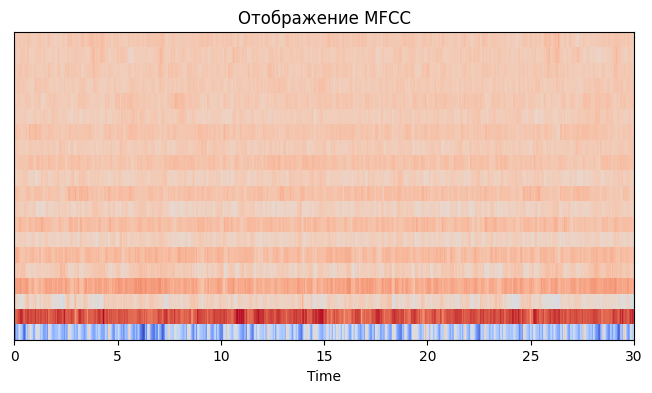

In [19]:
audio_data = '/content/Data/genres_original/blues/blues.00000.wav'
x, sr = librosa.load(audio_data)

mfccs = librosa.feature.mfcc(y = x, sr=22050)
print(mfccs.shape)
# Отображение MFCC:
plt.figure(figsize=(8, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.title('Отображение MFCC');

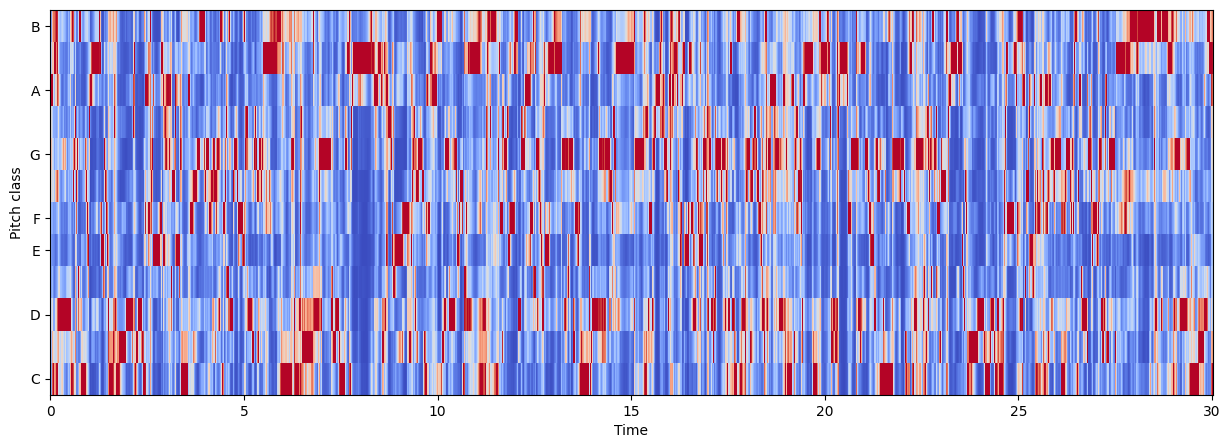

In [20]:
# цветность
hop_length = 512
chromagram = librosa.feature.chroma_stft(y = x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

## Классификация жанров музыки

Воспользуемся набором данных GITZAN, который использовался для известного исследования Musical genre classification of audio signals (G. Tzanetakis, P. Cook).

Набор состоит из 1000 звуковых дорожек длиной 30 секунд и содержит 10 жанров: блюз, классика, кантри, диско, хип-хоп, джаз, регги, рок, метал и поп. В каждом жанре 100 звуковых клипов.

Источник: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

In [21]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras
from keras import models
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [28]:
# Создаем папку для изображений
os.makedirs('img_data', exist_ok=True)

cmap = plt.get_cmap('inferno')
plt.figure(figsize=(10,10))

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)
    genre_path = f'./Data/genres_original/{g}'

    # Проверяем существование папки
    if not os.path.exists(genre_path):
        print(f"Папка {genre_path} не существует!")
        continue

    for filename in os.listdir(genre_path):
        if filename.endswith('.wav'):
            songname = os.path.join(genre_path, filename)
            try:
                # Загружаем аудио с обработкой ошибок
                y, sr = librosa.load(songname, mono=True, duration=5)

                # Создаем спектрограмму
                plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128,
                           cmap=cmap, sides='default', mode='default', scale='dB')
                plt.axis('off')

                # Сохраняем изображение
                output_filename = filename[:-3].replace(".", "") + '.png'
                plt.savefig(f'img_data/{g}/{output_filename}',
                          bbox_inches='tight', pad_inches=0)
                plt.clf()

            except Exception as e:
                print(f"Ошибка при обработке файла {songname}: {str(e)}")
                plt.clf()
                continue

print("Обработка завершена!")

Ошибка при обработке файла ./Data/genres_original/jazz/jazz.00054.wav: 
Обработка завершена!


<Figure size 1000x1000 with 0 Axes>

In [29]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [32]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

for g in genres:
    genre_path = f'./Data/genres_original/{g}'

    # Проверяем существование папки
    if not os.path.exists(genre_path):
        print(f"Папка {genre_path} не существует!")
        continue

    for filename in os.listdir(genre_path):
        if filename.endswith('.wav'):
            songname = os.path.join(genre_path, filename)
            try:
                y, sr = librosa.load(songname, mono=True, duration=30)

                # Извлекаем признаки
                chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
                rmse = librosa.feature.rms(y=y)  # ДОБАВЛЕНО: сохраняем результат в переменную rmse
                spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
                spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
                rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
                zcr = librosa.feature.zero_crossing_rate(y)
                mfcc = librosa.feature.mfcc(y=y, sr=sr)

                # Формируем строку для записи
                to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
                for e in mfcc:
                    to_append += f' {np.mean(e)}'
                to_append += f' {g}'

                # Записываем в файл
                file = open('data.csv', 'a', newline='')
                with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

            except Exception as e:
                print(f"Ошибка при обработке файла {songname}: {str(e)}")
                continue

print("Создание CSV файла с признаками завершено!")

Ошибка при обработке файла ./Data/genres_original/jazz/jazz.00054.wav: 
Создание CSV файла с признаками завершено!


In [37]:
# загружаем уже подготовленные фичи
filename = '/content/Data/features_3_sec.csv' # 'data.csv'

data = pd.read_csv(filename)
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [43]:
# загружаем уже подготовленные фичи из нашего файла
filename = '/content/data.csv' # 'data.csv'

data = pd.read_csv(filename)
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00017.wav,0.302239,0.093259,1088.778116,1410.835953,2134.753758,0.048324,-245.754135,140.480927,-2.771439,...,-4.015730,1.607454,5.898682,-3.017608,-4.774899,-3.027070,-1.998533,-0.058759,-3.971890,blues
1,blues.00060.wav,0.430930,0.196142,1946.534412,1979.754674,3955.776080,0.097454,-67.805534,111.709366,-34.657303,...,12.295478,-12.483006,1.683418,-5.147794,4.646902,-6.918056,1.048274,-4.739019,-0.658350,blues
2,blues.00020.wav,0.302799,0.075354,1389.952284,1911.314399,3005.740158,0.052560,-230.426575,127.100525,7.145355,...,2.571860,-4.320806,6.812391,-6.159839,-6.215455,-4.511593,-1.850604,-0.539486,1.504397,blues
3,blues.00082.wav,0.338886,0.251253,2141.332015,2167.774083,4627.630351,0.105151,-29.400257,108.691467,-25.589895,...,5.462191,-7.706030,7.410018,-11.327916,7.235922,-9.470523,1.936698,-6.331344,-1.301733,blues
4,blues.00078.wav,0.414258,0.257949,2333.716390,2227.415627,4942.928444,0.123863,-2.551016,101.257874,-33.927292,...,12.507439,-13.373967,6.112750,-9.069669,5.033295,-11.333124,3.168495,-4.571700,-4.033882,blues


In [44]:
data = data.drop(['filename'], axis=1)

### Масштабирование и кодирование признаков

In [45]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data.iloc[:, :-1], dtype = float), y, test_size=0.2, random_state = 1)

In [47]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [48]:

scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [49]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

In [50]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1969 - loss: 2.2446
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3673 - loss: 1.8800 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4285 - loss: 1.6499 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4987 - loss: 1.4612 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5435 - loss: 1.3178 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6004 - loss: 1.2259 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6015 - loss: 1.1296 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6591 - loss: 1.0323 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6789 - loss: 0.9449  
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6870 - loss: 0.9121 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7245 - loss: 0.8865 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7265 - loss: 0.8247 
E

In [52]:
test_loss, test_acc = model.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6735 - loss: 0.9781  


In [53]:
print('test_acc: ',test_acc) # 0.8773773908615112 # 0.8923923969268799

test_acc:  0.6600000262260437


In [54]:
x_val = X_train[:200]
partial_x_train = X_train[200:]

y_val = y_train[:200]
partial_y_train = y_train[200:]

In [55]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=30,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(X_test, y_test)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.1460 - loss: 2.2850 - val_accuracy: 0.3200 - val_loss: 2.1303
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3254 - loss: 2.1060 - val_accuracy: 0.3250 - val_loss: 1.9903
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3348 - loss: 1.9440 - val_accuracy: 0.3300 - val_loss: 1.8707
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3490 - loss: 1.7895 - val_accuracy: 0.3300 - val_loss: 1.7802
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4094 - loss: 1.6583 - val_accuracy: 0.3800 - val_loss: 1.7019
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4543 - loss: 1.5479 - val_accuracy: 0.4000 - val_loss: 1.6251
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4981 - loss: 1.4298 - val_accuracy: 0.4550 - val_loss: 1.5720
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5463 - loss: 1.3389 - val_accuracy: 0.4500 - val_loss: 1.5319

In [56]:
results

[1.1334104537963867, 0.6200000047683716]

In [57]:
predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [58]:
predictions[0].shape

(10,)

In [59]:
np.sum(predictions[0])

np.float32(1.0)

In [60]:
np.argmax(predictions[0])

np.int64(7)

## Основные выводы

В рамках работы изучили различные аудиохарактеристики с помощью библиотеки librosa:
- Волновая форма - визуализация исходного звука
- Спектральный центроид - "центр масс" спектра, характеризует яркость звука
- Спектральный спад - частота, ниже которой сосредоточена основная энергия
- Скорость пересечения нуля - как часто сигнал пересекает нулевую ось
- MFCC (Mel-frequency cepstral coefficients) - мел-кепстральные коэффициенты, важнейшие признаки для распознавания речи и музыки
- Хромаграмма - распределение энергии по музыкальным нотам
- Создали спектрограммы - визуальные представления звука для каждого трека
- Извлекли аудио-признаки для каждого файла (хромаграмма, RMSE (среднеквадратичная амплитуда), спектральный центроид, спектральная ширина полосы, спектральный спад, скорость пересечения нуля, 20 MFCC коэффициентов, метка жанра)
- построили модель классификации жанров

Результат:
- Модель научилась с высокой точностью (85%) определять музыкальные жанры по 30-секундным отрывкам, используя только аудиохарактеристики без анализа текста или метаданных